# [5-5] colorRecognition

JETANK 색상인식
이 문서는 프레임 내의 특정 픽셀의 HSV 값을 획득하여 후속 색상 추적 기능에 사용합니다.  
HSV 색상 휠은 때로는 원뿔 또는 원통으로 나타날 수 있지만 항상 세 가지 구성 요소를 가집니다.  
색상은 모델의 색상 부분으로, 0에서 360도(OpenCV에서는 0에서 180도)까지의 숫자로 표시됩니다.  
적색은 0에서 60도 사이에 있습니다.  노랑은 61에서 120도 사이에 있습니다.  녹색은 121에서 180도 사이에 있습니다.  청록은 181에서 240도 사이에 있습니다.   
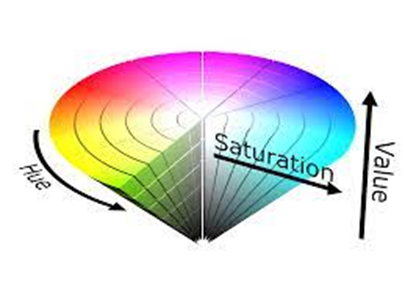

한편 RGB 색상 값은 다음과 같이 지정됩니다: rgb (빨강, 초록, 파랑).  
각 매개변수(빨강, 초록, 파랑)는 색상의 강도를 0에서 255 사이의 정수로 정의합니다.  
예를 들어 rgb (0, 0, 255)는 파란색으로 렌더링됩니다.  
파란 매개변수가 최고값(255)으로 설정되고 다른 값은 0으로 설정되기 때문입니다.  
따라서 색상 인식 기능에서 환경의 화이트 밸런스와 조명 밝기 차이의 영향을 피하기 위해 HSV 색 공간을 사용하여 색상을 일치시킵니다.

## Import camera function libraries

다음 코드 블록을 실행한 후에는 잠시 기다렸다가 카메라가 초기화되기를 기다리십시오. 초기화가 성공하면 300x300 크기의 실시간 비디오 화면이 코드 블록 아래에 나타납니다.

In [1]:
import traitlets
import ipywidgets
from IPython.display import display
from jetbot import Camera, bgr8_to_jpeg

camera = Camera.instance(width=300, height=300)
#Camera 객체의 instance 생성 가로X세로
image_widget = ipywidgets.Image()  # this width and height doesn't necessarily have to match the camera
#이미지 위젯의 속성 설정, 가로X세로가 camera 와 같을 필요는 없음
camera_link = traitlets.dlink((camera, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)
#traitlets.dlink 단방향 링크(Unidirectional Link) 
#왼쪽 속성의 값이 변경되면 오른쪽 속성의 값도 변경되지만 그 반대는 성립하지 않음을 의미하는 방향 링크.
#카메라의 value가 바뀌면 image의 value도 바뀌|지만 그 반대는 성립 X
display(image_widget)
#출력

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

## Convert the frame to HSV color space

프레임을 HSV 색 공간으로 변환합니다.  
다음 코드는 프레임을 HSV 색 공간으로 변환하고, 샘플링해야 하는 픽셀의 정렬을 용이하게하기 위해 프레임에 일부 요소를 그립니다.  
주의: 다음 코드를 실행한 후에는 보이는 프레임이 변경되지 않습니다. image_widget.value의 값이 변경되고 camera.observe() 함수가 호출된 후에만 최종 효과를 관찰할 수 있습니다.  
전자의 값은 처리된 프레임을 표시하는 데 사용되고, 후자 함수는 새 프레임이 수집된 직후 즉시 이미지 처리 관련 메서드를 호출하는 데 사용됩니다.  

In [2]:
import cv2

# 이 함수에서 수집된 프레임을 가져와 처리합니다.
def colorSelect(imageInput):
    # HSV 영역으로 변환합니다.
    hsv = cv2.cvtColor(imageInput, cv2.COLOR_BGR2HSV)
    
    # 노이즈를 줄이기 위해 blur 처리를 합니다.
    hsv = cv2.blur(hsv, (15, 15))
    
    # 중심 좌표의 HSV 값을 가져옵니다.
    # 스크린 크기가 300x300 이므로, 중심 pixel 위치는 (150, 150) 입니다..
    hsvValue = hsv[150, 150]
    
    # 중심 좌표를 기준으로 20x20 사각형을 그립니다.
    cv2.rectangle(imageInput,(140,140),(160,160),(255,255,255),1)
    
    # HSV 값을 프레임에 출력합니다.
    cv2.putText(imageInput,"HSV:{}".format(hsvValue),(80,180), cv2.FONT_HERSHEY_SIMPLEX,
 0.5,(255,255,255),1,cv2.LINE_AA)
    
    # 프레임을 반환합니다.
    return imageInput

## Process video frames and display

다음 코드를 실행한 후에는 프레임의 색상이 변경된 것을 볼 수 있습니다. 이는 비디오 프레임이 colorSelect() 함수에 의해 성공적으로 처리되었음을 나타냅니다.

In [3]:
def execute(change):
    global image_widget
    image = change['new']
    image_widget.value = bgr8_to_jpeg(colorSelect(image))
    
execute({'new': camera.value})
camera.unobserve_all()
camera.observe(execute, names='value')

비디오 화면에 작은 흰색 사각형이 있습니다. 이 작은 사각형을 사용하여 가져오려는 객체를 정렬하세요.  
객체를 정렬한 후에는 사각형 아래의 HSV 값을 일정 범위 내에서 변경됩니다. 이 세 가지 값의 최대값과 최소값을 기록하세요.  
예를 들어, colorUpper = [44, 255, 255], colorLower = [24, 100, 100]와 같습니다.  

## 질문: 왜 이 값을 평균화하거나 여러 번 샘플링하는 대신 빠르게 변경해야 합니까?
왜냐하면 블러링 후에 이 픽셀은 주변 픽셀과 평균화된 결과입니다.  
이 영역에서 개별 픽셀의 값 변동 범위를 고려해야 하므로 여러 번 샘플링하고 평균화하는 대신 이 값이 빠르게 변경되어야 합니다.  
이렇게 하면 실제 화면에서 색상의 HSV 값 범위가 크게 줄어들고, 후속 색상 인식 관련 기능의 작업 효율이 저하될 수 있습니다.  

## Turn off this function processing and stop the camera

이 함수 처리를 중지하고 카메라를 종료하세요. 

In [4]:
camera.unobserve(execute, names='value')

다음 노트북에서도 카메라를 사용할 수 있도록 다시 한번 카메라 연결을 제대로 닫도록 하겠습니다.

In [5]:
camera.stop()